Import libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from numpy import array
from statistics import mean
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

Load data

In [37]:
train_df = pd.read_csv("TrainingWiDS2021.csv")
test_df = pd.read_csv("UnlabeledWiDS2021.csv")

Drop unnecessary columns

In [38]:
# Drop unnamed column
train_df = train_df.drop(columns=['Unnamed: 0'])
test_df = test_df.drop(columns=['Unnamed: 0'])

In [39]:
# Drop ID columns
train_df.drop(['encounter_id', 'hospital_id', 'icu_id'], axis=1)
test_df.drop(['encounter_id', 'hospital_id', 'icu_id'], axis=1)

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,72,NaN,0,Caucasian,F,152.4,Floor,Accident & Emergency,admit,Med-Surg ICU,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,86,NaN,0,Caucasian,F,175.3,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,72,NaN,0,Caucasian,F,162.6,Floor,Floor,admit,Med-Surg ICU,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,66,NaN,0,Caucasian,M,177.8,Floor,Floor,admit,Med-Surg ICU,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,89,NaN,0,Caucasian,M,170.2,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,...,NaN,NaN,NaN,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10229,36,37.5,0,Caucasian,F,170.1,Floor,Floor,admit,Med-Surg ICU,...,NaN,NaN,NaN,0,0,0,0,0,0,0
10230,61,32.1,0,Caucasian,F,160.0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,NaN,NaN,NaN,0,0,0,0,0,0,0
10231,74,22.7,0,Caucasian,F,165.1,Step-Down Unit (SDU),Floor,admit,Med-Surg ICU,...,NaN,NaN,NaN,0,0,0,0,0,0,0
10232,90,19.9,0,Caucasian,F,160.0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,NaN,NaN,NaN,0,0,0,0,0,0,0


Train data

In [24]:
X = train_df.drop('diabetes_mellitus', axis=1)
y = train_df['diabetes_mellitus']

kf = KFold(n_splits=5, random_state=42, shuffle=True)

auc = []

Gradient Boosting

In [7]:
k = 1

for train_index, val_index in kf.split(X):
    # Split data
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Fill in NaNs
    train_mode = X_train[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']].mode(axis=0).iloc[0]
    X_train[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']] = X_train[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']].fillna(train_mode)
    X_val[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']] = X_val[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']].fillna(train_mode)
        
    train_median = train_df.median(axis=0)
    X_train.fillna(train_median, inplace=True)
    X_val.fillna(train_median, inplace=True)
    
    # One-hot encode
    encoder = OneHotEncoder(handle_unknown='ignore') 
    train_encoded = encoder.fit_transform(array(X_train[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']])).toarray()
    names = encoder.get_feature_names(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type'])
    X_train[names] = train_encoded
    X_val[names] = encoder.transform(array(X_val[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']])).toarray()
    X_train.drop(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type'], axis=1, inplace=True)
    X_val.drop(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type'], axis=1, inplace=True)
    
    # Fit model
    gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
    gradient_booster.fit(X_train, y_train)
    
    prediction = gradient_booster.predict_proba(X_val)[:, 1]
    auc.append(roc_auc_score(y_val, prediction))
    print('AUC', str(k), ':', roc_auc_score(y_val, prediction))
    
    k += 1
    
print('Mean AUC with GBM:', mean(auc))

print(classification_report(y_val, gradient_booster.predict(X_val)))

AUC 1 : 0.8460453923160703
AUC 2 : 0.8475258555875326
AUC 3 : 0.8503005819083644
AUC 4 : 0.8473702849675685
AUC 5 : 0.8483775582596154
Mean AUC with GBM: 0.8479239346078302
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     20411
           1       0.65      0.43      0.52      5620

    accuracy                           0.83     26031
   macro avg       0.76      0.68      0.71     26031
weighted avg       0.81      0.83      0.81     26031



XGBoost

In [8]:
k = 1

for train_index, val_index in kf.split(X):
    # Split data
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Fill in NaNs
    train_mode = X_train[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']].mode(axis=0).iloc[0]
    X_train[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']] = X_train[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']].fillna(train_mode)
    X_val[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']] = X_val[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']].fillna(train_mode)
        
    train_median = train_df.median(axis=0)
    X_train.fillna(train_median, inplace=True)
    X_val.fillna(train_median, inplace=True)
    
    # One-hot encode
    encoder = OneHotEncoder(handle_unknown='ignore') 
    train_encoded = encoder.fit_transform(array(X_train[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']])).toarray()
    names = encoder.get_feature_names(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type'])
    X_train[names] = train_encoded
    X_val[names] = encoder.transform(array(X_val[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']])).toarray()
    X_train.drop(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type'], axis=1, inplace=True)
    X_val.drop(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type'], axis=1, inplace=True)
    
    # Fit XGBoost
    xgb_classifier = XGBClassifier(learning_rate=0.1)
    xgb_classifier.fit(X_train, y_train)
    
    prediction = xgb_classifier.predict_proba(X_val)[:, 1]
    auc.append(roc_auc_score(y_val, prediction))
    print('AUC', str(k), ':', roc_auc_score(y_val, prediction))
    
    k += 1
    
print('Mean AUC with XGBoost:', mean(auc))

print(classification_report(y_val, xgb_classifier.predict(X_val)))

[17:12:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC 1 : 0.8612786716230987
[17:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC 2 : 0.8635421685097429
[17:14:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC 3 : 0.864946

Predict on test data

In [40]:
labels = train_df['diabetes_mellitus']
train_df.drop(['diabetes_mellitus'], axis=1, inplace=True)

In [41]:
# Fill in NaNs
train_mode = train_df[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']].mode(axis=0).iloc[0]
train_df[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']] = train_df[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']].fillna(train_mode)
test_df[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']] = test_df[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']].fillna(train_mode)

train_median = train_df.median(axis=0)
train_df.fillna(train_median, inplace=True)
test_df.fillna(train_median, inplace=True)

# One-hot encode
encoder = OneHotEncoder(handle_unknown='ignore') 
train_encoded = encoder.fit_transform(array(train_df[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']])).toarray()
names = encoder.get_feature_names(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type'])
train_df[names] = train_encoded
test_df[names] = encoder.transform(array(test_df[['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']])).toarray()
train_df.drop(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type'], axis=1, inplace=True)
test_df.drop(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type'], axis=1, inplace=True)

# Fit XGBoost
xgb_classifier = XGBClassifier(learning_rate=0.1)
xgb_classifier.fit(train_df, labels)

prediction = xgb_classifier.predict_proba(test_df)[:, 1]
submission = pd.DataFrame()
submission['encounter_id'] = test_df['encounter_id']
submission['diabetes_mellitus'] = prediction

[18:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:ylabel='Frequency'>

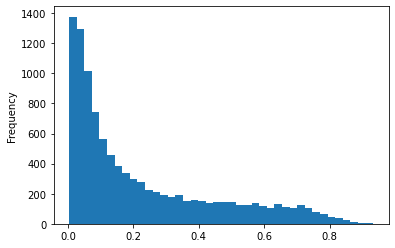

In [42]:
submission['diabetes_mellitus'].plot.hist(bins=40)

In [44]:
submission.to_csv("kg_submission2.csv", index=False)

In [43]:
xgb_classifier.feature_importances_

array([0.00243687, 0.00860312, 0.01090766, 0.01464536, 0.00374894,
       0.00217471, 0.01562296, 0.00403665, 0.        , 0.00835921,
       0.00259214, 0.00689405, 0.00754916, 0.        , 0.01285529,
       0.00416441, 0.00442533, 0.00444138, 0.00325654, 0.00650306,
       0.02618697, 0.00641127, 0.02823417, 0.00660244, 0.00661543,
       0.00350841, 0.00349098, 0.00272827, 0.00306439, 0.        ,
       0.00364325, 0.00258828, 0.00361031, 0.00416208, 0.00406471,
       0.00406163, 0.02297471, 0.00367409, 0.00563693, 0.00622988,
       0.00409105, 0.00292817, 0.00457812, 0.00410187, 0.00604507,
       0.00361346, 0.00243013, 0.0029243 , 0.00244105, 0.00216067,
       0.00276356, 0.00237706, 0.00341271, 0.00488854, 0.00354449,
       0.00294446, 0.00521289, 0.0043808 , 0.00592088, 0.00414991,
       0.00496737, 0.00347037, 0.00270291, 0.00421228, 0.00345063,
       0.00434704, 0.00350773, 0.00498734, 0.00293686, 0.00636464,
       0.00207589, 0.00314976, 0.00162792, 0.00352883, 0.00242

In [20]:
xgb_classifier.feature_importances_.tolist().index(1)

173

In [23]:
train_df.columns.tolist()[173]

'diabetes_mellitus'

In [27]:
train_df['diabetes_mellitus']

0         1
1         1
2         0
3         0
4         0
         ..
130152    0
130153    0
130154    1
130155    0
130156    0
Name: diabetes_mellitus, Length: 130157, dtype: int64